In [26]:
import datetime
import copy


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)

In [27]:
plt.style.use('ggplot')

In [3]:
data_W = pd.read_excel(r"data/Hourly Weather and No Outlier Wachapreague Data.xlsx", parse_dates=[r"Date"])
data_W = data_W.drop(
    columns=["Wind Direction (degrees)", "Water Level Anomalies (m)"]
    ).rename(
    columns = {"Date": "time_min", 
                "Wind Speed (m/s)": "wind",
               "Air Pressure (mb)": "airpressure",
               "Precipitation (mm/hr)": "precipitation", 
               "Temperature ©": "temperature",
               "Salinity (ppt)": "salinity",
               "DO (mg/L)": "ODO",
               "Water Level (m)": "waterlevel",
               "Log10(Chl+1) (log10(ug/L))": "log10_chlorophyll",
              }
    ).set_index("time_min")

data_W["chlorophyll"] = data_W["log10_chlorophyll"].map(lambda x: np.power(10, x))
data_W["date"] = data_W.index.date
#data_W = data_W.dropna()

# data_W = pd.read_excel(r"data/Corrected W All.xlsx", sheet_name = "Sheet1", parse_dates=[r"Combine"],)
# data_W = data_W.drop(
#     columns=["MM/DD/YY", "HH:mm:SS", "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "Unnamed: 15"]
#     ).rename(
#     columns = {"Combine": "time_min",
#                "Temp ('C)": "temperature",
#                "SpCond (ms/cm)": "conductivity",
#                "Salinity (ppt)": "salinity",
#                "ODO (mg/L)": "ODO",
#                "Turb (NTU)": "turbidity",
#                "Chl (ug/L)": "chlorophyll",
#               }
#     ).set_index("time_min")
# data_W["date"] = data_W.index.date
# data_W["log10_chlorophyll"] = data_W["chlorophyll"].map(np.log10)
# data_W = data_W.dropna()


In [4]:
data_W

,wind,airpressure,precipitation,temperature,salinity,ODO,log10_chlorophyll,waterlevel,chlorophyll,date
time_min,,,,,,,,,,
2016-03-25 20:00:00,1.870,1012.210000,0.76,16.70975,30.9550,8.0425,0.360495,0.938,2.293480,2016-03-25
2016-03-25 21:00:00,2.500,1013.730000,0.53,16.43975,31.2575,7.8200,0.319070,1.127,2.084826,2016-03-25
2016-03-25 22:00:00,3.690,1014.980000,0.20,15.83275,31.4425,7.8650,0.327645,1.268,2.126401,2016-03-25
2016-03-25 23:00:00,4.180,1015.490000,0.03,15.43950,31.4775,7.8525,0.330899,1.324,2.142390,2016-03-25
2016-03-26 00:00:00,3.150,1016.750000,0.00,15.45900,31.3925,7.7400,0.325592,1.238,2.116372,2016-03-26
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,0.625,1011.325000,0.02,7.93175,30.2575,10.6000,0.358752,0.8,2.284292,2022-12-31
2022-12-31 19:00:00,1.800,1011.310000,NaN,8.10550,30.1100,10.5450,0.359835,NaN,2.289997,2022-12-31
2022-12-31 20:00:00,2.120,1010.420000,NaN,8.65100,28.9200,10.2250,0.429598,NaN,2.689042,2022-12-31


In [5]:

data_WW = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "WW", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw (1).xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )

data_WW = data_WW.drop(
    columns=["Unnamed: 17", "Unnamed: 18", "MM/DD/YY.1", "Flagged or Deleted Data/Notes", "Log10 chl", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)", "Day"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW_2 = data_WW_2.drop(
    columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = pd.concat([data_WW[data_WW.index.year < 2022], data_WW_2])
data_WW["log10_chlorophyll"] = data_WW["chlorophyll"].map(np.log10)
#data_WW = data_WW.dropna()


d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)
d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


In [6]:
data_WW

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104
...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721


## EDA (WW)

In [7]:

# # 1stmax
# data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# # 2ndmax
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

# 90-quantile
data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
data_WW_byday["date"] = data_WW["date"].resample("1D").max()
data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)


In [8]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()
#data_W_byday["waterlevel"] = data_W["waterlevel"].resample("1D").mean()


In [9]:
data_WW_byday

,temperature,pH,date,conductivity,turbidity,ODO,salinity_max,salinity_min,log10_chlorophyll,chlorophyll
time_min,,,,,,,,,,
2018-10-12,24.194146,7.902439,2018-10-12,46.4970,39.810,6.430,30.200,28.660,1.246991,17.660
2018-10-13,22.100917,7.863437,2018-10-13,46.5795,23.665,5.950,30.275,28.535,1.322623,21.020
2018-10-14,20.642937,7.871354,2018-10-14,46.3725,15.745,6.270,30.150,28.765,1.208680,16.170
2018-10-15,21.330021,7.870104,2018-10-15,46.2745,13.905,6.420,30.080,28.815,1.196650,15.730
2018-10-16,21.417677,7.843646,2018-10-16,46.1905,13.850,5.890,30.015,28.750,1.096733,12.495
...,...,...,...,...,...,...,...,...,...,...
2022-12-20,5.802531,7.942708,2022-12-20,48.5670,4.475,9.565,31.140,28.980,0.346349,2.220
2022-12-21,5.474958,7.948021,2022-12-21,49.0295,5.905,9.665,31.435,29.370,0.400537,2.515
2022-12-22,5.977583,7.944375,2022-12-22,49.4285,12.655,9.785,31.770,29.760,0.449472,2.815


In [10]:
data_W_byday

,date,airpressure,wind
time_min,,,
2016-03-25,2016-03-25,1014.102500,3.060000
2016-03-26,2016-03-26,1023.828333,4.754167
2016-03-27,2016-03-27,1023.604583,5.606726
2016-03-28,2016-03-28,1008.585417,2.056726
2016-03-29,2016-03-29,1018.340417,2.348611
...,...,...,...
2022-12-27,2022-12-27,1025.706296,0.682335
2022-12-28,2022-12-28,1026.914643,1.003393
2022-12-29,2022-12-29,1027.514821,1.933671


In [11]:
data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).dropna()

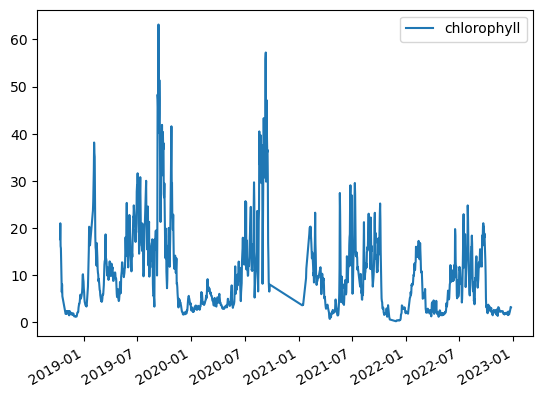

In [12]:
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

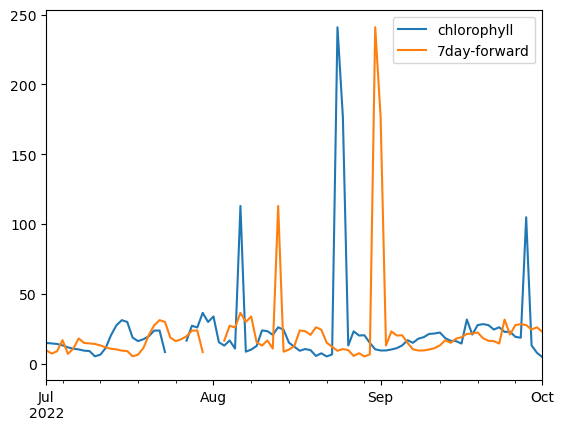

In [15]:
data_WW_byday["7day-forward"] = data_WW_byday["chlorophyll"].shift(7)
data_WW_byday[["chlorophyll", "7day-forward"]].plot()
plt.legend()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim((pd.Timestamp("2022-07-01"), pd.Timestamp("2022-10-01")))
plt.show()

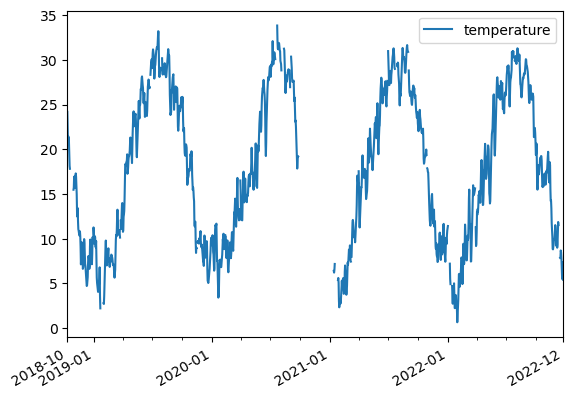

In [16]:
data_WW_byday["temperature"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

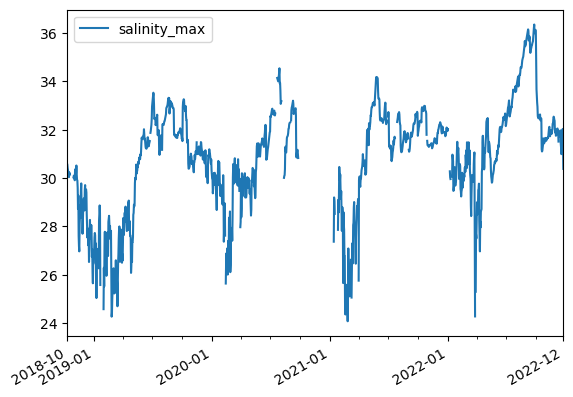

In [17]:
data_WW_byday["salinity_max"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

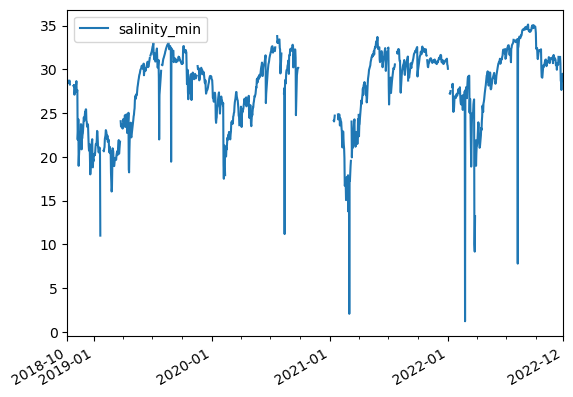

In [18]:
data_WW_byday["salinity_min"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

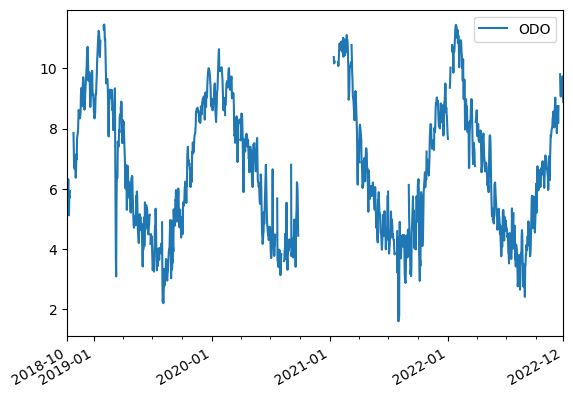

In [19]:
data_WW_byday["ODO"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

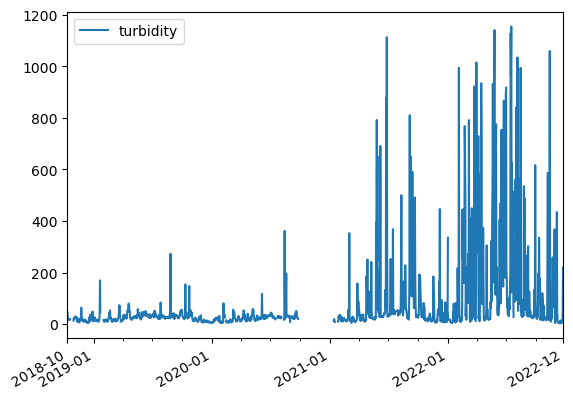

In [20]:
data_WW_byday["turbidity"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

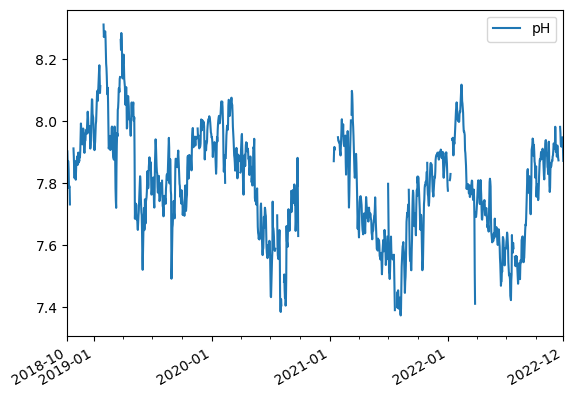

In [21]:
data_WW_byday["pH"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

In [29]:
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

data_WW_byday["chlorophyll_2"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


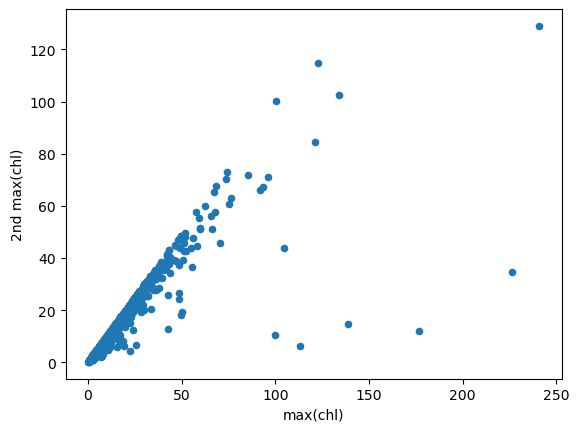

In [33]:
data_WW_byday.plot.scatter(x = "chlorophyll", y = "chlorophyll_2")
plt.xlabel("max(chl)")
plt.ylabel("2nd max(chl)")
plt.show()

## EDA (W)

In [22]:
data_W_byday = data_W[["date", "conductivity", "turbidity"]].resample("1D").max()
data_W_byday["temperature"] = data_W["temperature"].resample("1D").mean()
data_W_byday["pH"] = data_W["pH"].resample("1D").mean()
data_W_byday["ODO"] = data_W["ODO"].resample("1D").min()
data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").max()
data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").min()
data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").max()
data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").max()

# data_W_byday = data_W[["temperature", "pH"]].resample("1D").mean()
# data_W_byday["date"] = data_W["date"].resample("1D").max()
# data_W_byday["conductivity"] = data_W["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["turbidity"] = data_W["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["ODO"] = data_W["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


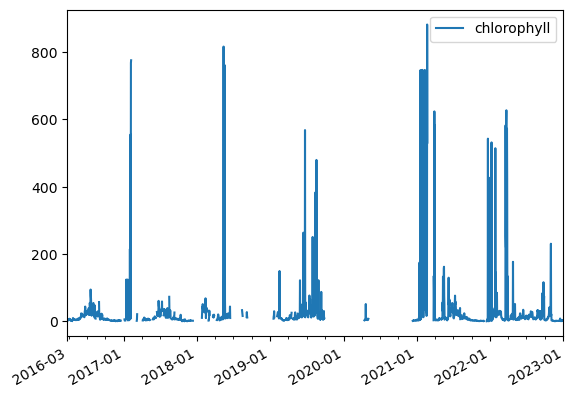

In [25]:
data_W_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

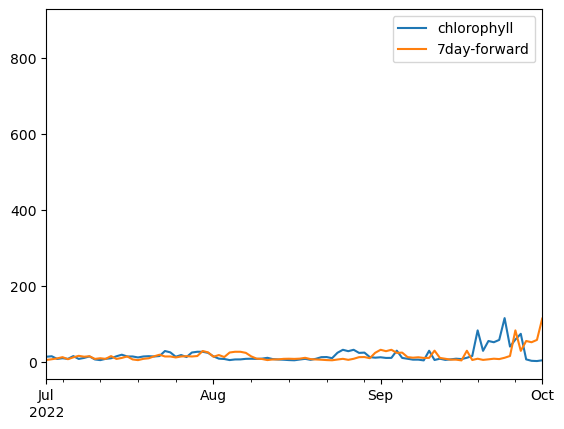

In [26]:
data_W_byday["7day-forward"] = data_W_byday["chlorophyll"].shift(7)
data_W_byday[["chlorophyll", "7day-forward"]].plot()
plt.legend()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim((pd.Timestamp("2022-07-01"), pd.Timestamp("2022-10-01")))
plt.show()

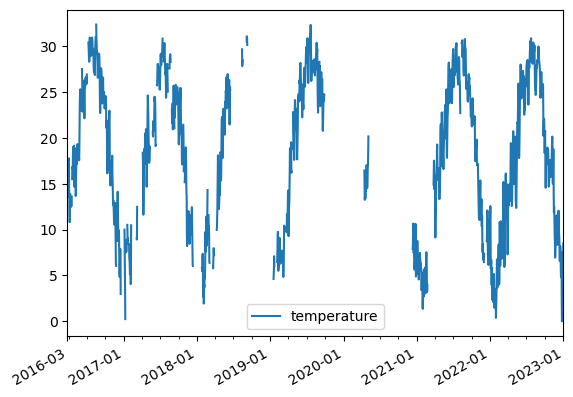

In [27]:
data_W_byday["temperature"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

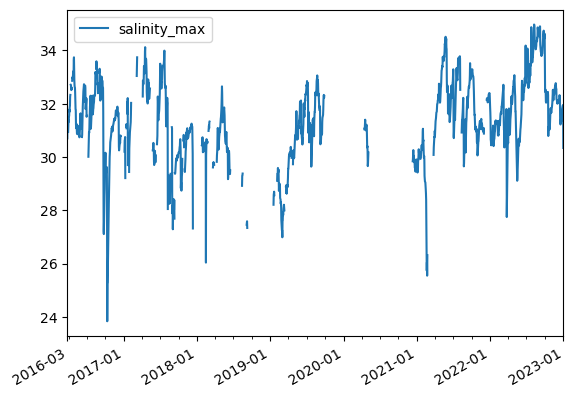

In [28]:
data_W_byday["salinity_max"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

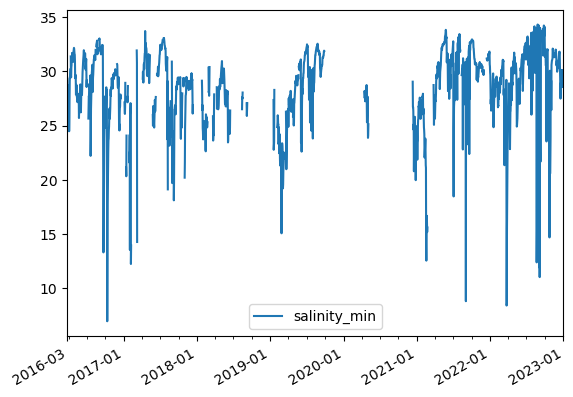

In [29]:
data_W_byday["salinity_min"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

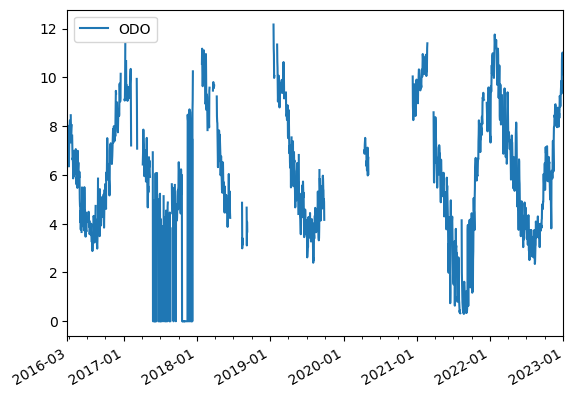

In [30]:
data_W_byday["ODO"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

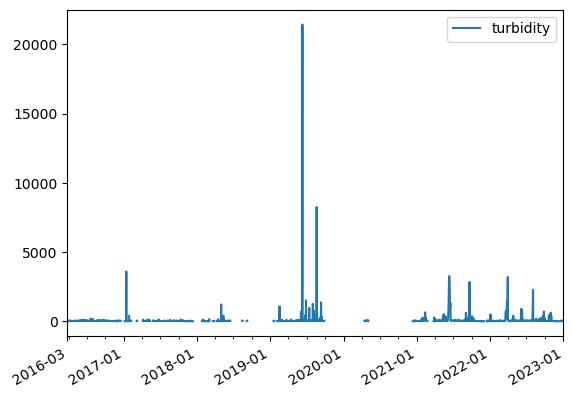

In [31]:
data_W_byday["turbidity"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

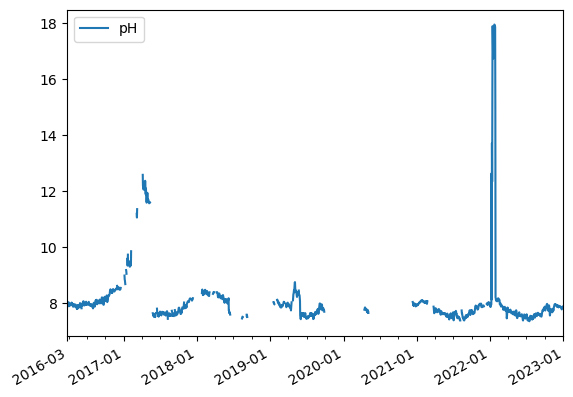

In [32]:
data_W_byday["pH"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

## EDA (W - Hourly)

In [39]:
data_W

,wind,airpressure,precipitation,temperature,salinity,ODO,log10_chlorophyll,waterlevel,chlorophyll
time_min,,,,,,,,,
2016-03-25 20:00:00,1.870000,1012.210000,0.76,16.70975,30.9550,8.0425,0.360495,0.938,2.293480
2016-03-25 21:00:00,2.500000,1013.730000,0.53,16.43975,31.2575,7.8200,0.319070,1.127,2.084826
2016-03-25 22:00:00,3.690000,1014.980000,0.20,15.83275,31.4425,7.8650,0.327645,1.268,2.126401
2016-03-25 23:00:00,4.180000,1015.490000,0.03,15.43950,31.4775,7.8525,0.330899,1.324,2.142390
2016-03-26 00:00:00,3.150000,1016.750000,0.00,15.45900,31.3925,7.7400,0.325592,1.238,2.116372
...,...,...,...,...,...,...,...,...,...
2022-12-30 09:00:00,1.970000,1027.990000,0.00,3.83875,30.2475,10.8475,0.256034,0.154,1.803160
2022-12-30 10:00:00,2.600000,1027.950000,0.00,3.88500,31.0050,11.0250,0.216035,0.408,1.644506
2022-12-30 17:00:00,0.850000,1024.550000,0.00,5.93050,31.7200,11.5850,0.402570,0.694,2.526794


In [43]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["temperature"] = data_W["temperature"].resample("1D").mean()
data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()
data_W_byday["waterlevel"] = data_W["waterlevel"].resample("1D").mean()
data_W_byday["ODO"] = data_W["ODO"].resample("1D").min()
data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").max()
data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").min()
data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").max()
data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").max()

# data_W_byday = data_W[["temperature", "pH"]].resample("1D").mean()
# data_W_byday["date"] = data_W["date"].resample("1D").max()
# data_W_byday["conductivity"] = data_W["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["turbidity"] = data_W["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["ODO"] = data_W["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


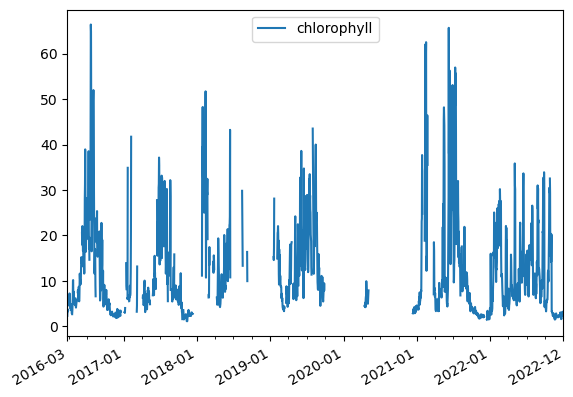

In [44]:
data_W_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

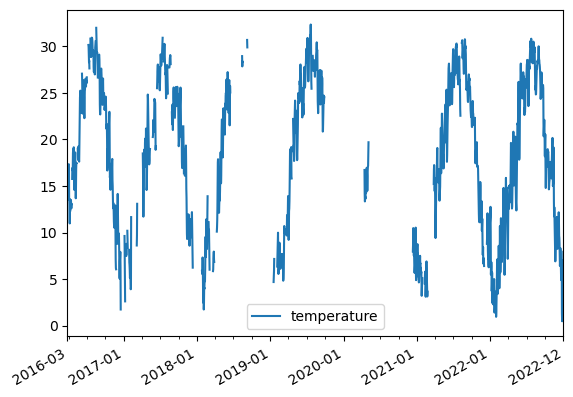

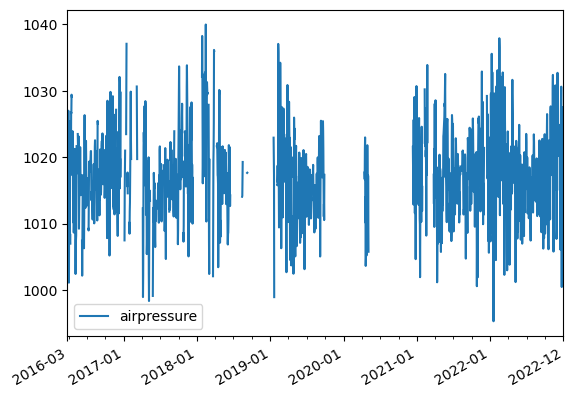

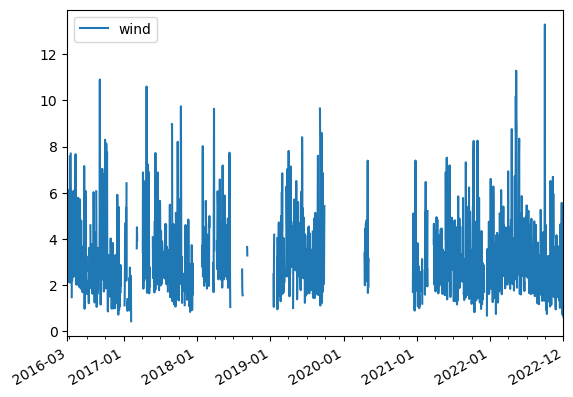

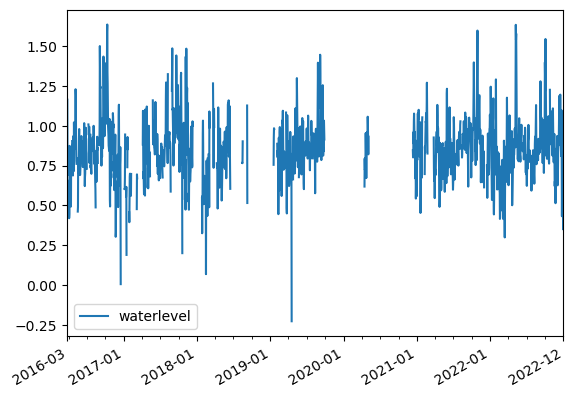

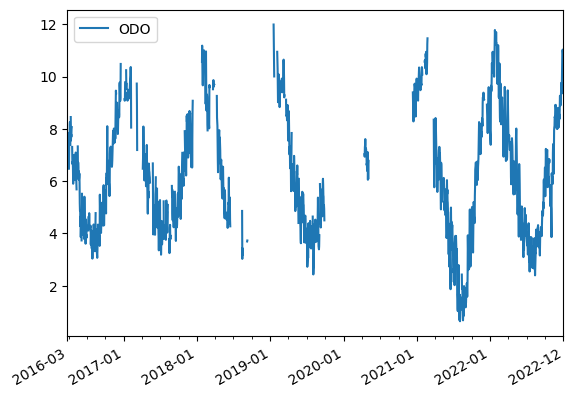

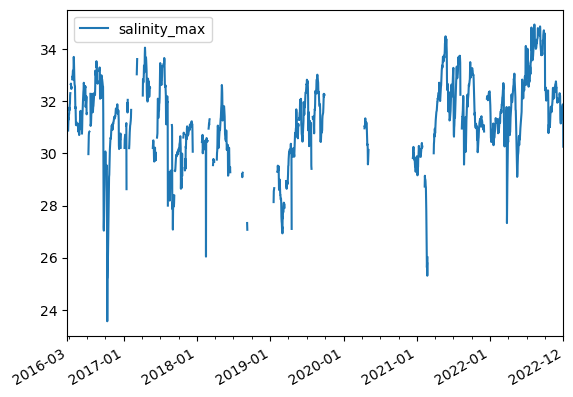

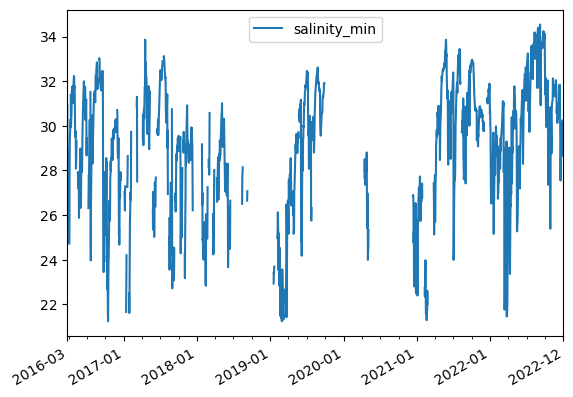

In [46]:
for tmp_col in ["temperature", "airpressure", "wind", "waterlevel", "ODO", "salinity_max", "salinity_min", ]:
    data_W_byday[tmp_col].plot()
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.xlabel("")
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


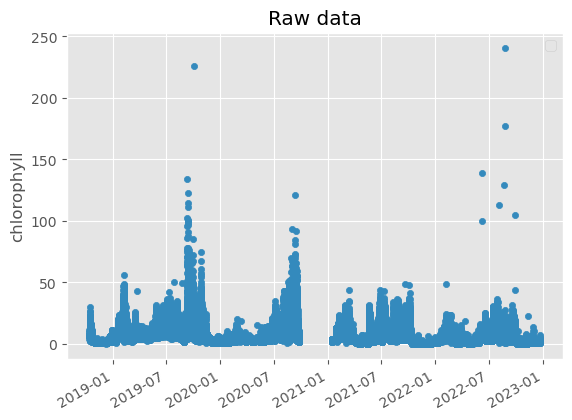

In [31]:
data_WW[["chlorophyll"]].reset_index().plot.scatter(x = 'time_min', y = 'chlorophyll')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")

plt.title("Raw data")
plt.savefig(r"plots/chl_plot_scatter.png", dpi = 300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


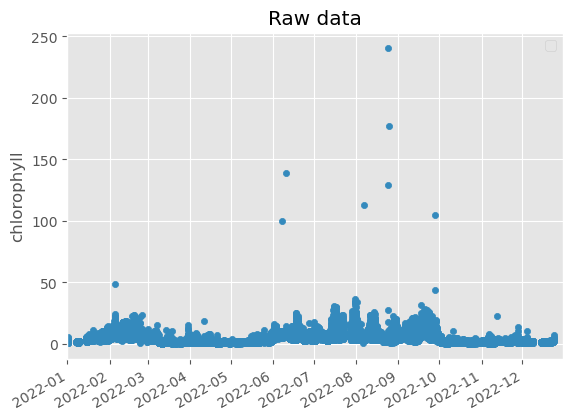

In [40]:
data_WW[["chlorophyll"]].reset_index().plot.scatter(x = 'time_min', y = 'chlorophyll')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2022-12-31"))

plt.title("Raw data")
plt.savefig(r"plots/chl_plot_scatter_2022.png", dpi = 300)
plt.show()

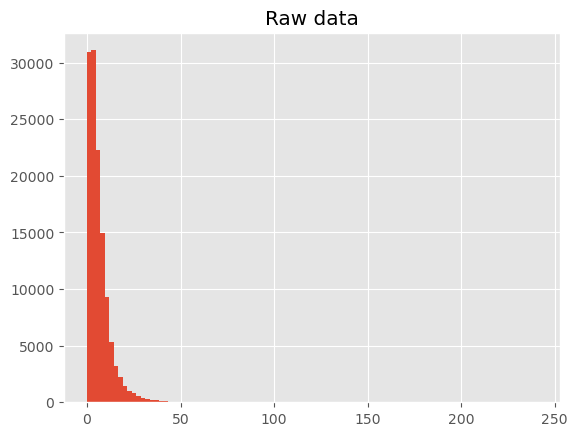

In [43]:
data_WW[["chlorophyll"]].reset_index()["chlorophyll"].hist(bins = 100)
plt.title("Raw data")

plt.savefig(r"plots/chl_hist.png", dpi = 300)
plt.show()

#### top-1, top-2, 90-Q

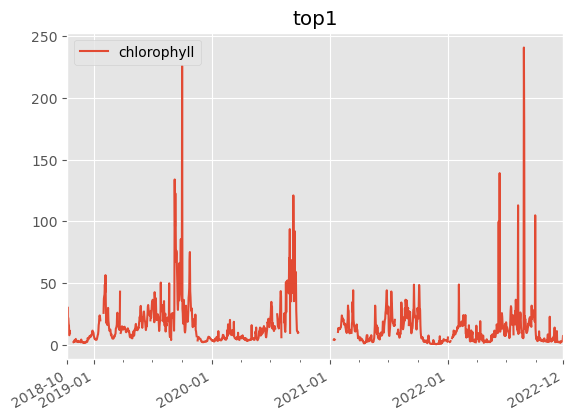

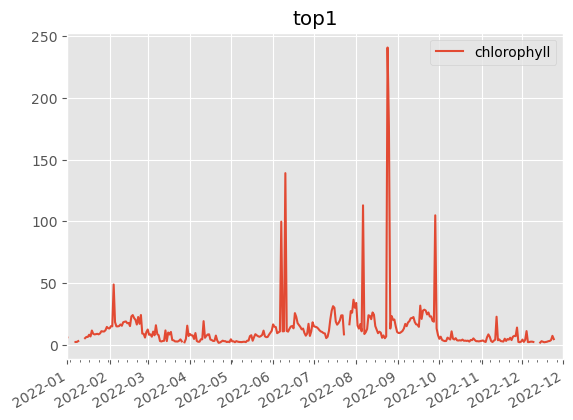

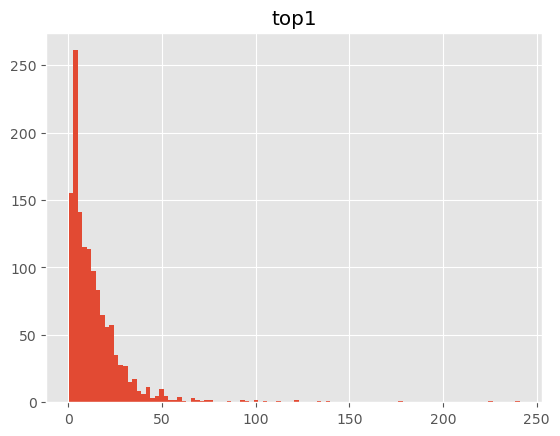

In [30]:

top_mode = "top1"
# top_mode = "top2"
# top_mode = "90Q"

if top_mode == "top1":
    data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
    data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
    data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
    data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
    data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
    data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
    data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
    data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()
elif top_mode == "top2":
    data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
    data_WW_byday["date"] = data_WW["date"].resample("1D").max()
    data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
    data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
    data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
    data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
    data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
    data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
    data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
elif top_mode == "90Q":
    data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
    data_WW_byday["date"] = data_WW["date"].resample("1D").max()
    data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
    data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
    data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
    data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
    data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
    data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
    data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
else:
    print("No top mode % s" % top_mode)

data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()
#data_W_byday["waterlevel"] = data_W["waterlevel"].resample("1D").mean()

data_WW_byday = data_WW_byday.resample("1D").max()

# plot all
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.title("% s" % top_mode)

plt.savefig(r"plots/chl_plot_% s.png" % top_mode, dpi = 300)
plt.show()

# plot 2022
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2022-12-31"))
plt.title("% s" % top_mode)

plt.savefig(r"plots/chl_plot_2022_% s.png" % top_mode, dpi = 300)
plt.show()

# plot hist
data_WW_byday["chlorophyll"].hist(bins = 100)
plt.title("% s" % top_mode)

plt.savefig(r"plots/chl_hist_% s.png" % top_mode, dpi = 300)
plt.show()


## Model

### Functions

In [6]:
class MSLR():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None):
        self.n_components = n_components
        self.n_iter = n_iter
        self.covariance_type = covariance_type 
        self.tol = 0.0
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        return
    
    
    def fit_predict(self, X, Y, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        n_seq = len(list_X)
        list_T = [len(i) for i in list_X]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        K = self.n_components
        self.n_features = p
        
        self.transmat_ = np.array([[1. / K for j in range(K)] for i in range(K)])

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(self.transmat_), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self.transmat_ = self._calc_transmat(list_tmp_array3d_log_epsilon)
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
        
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = self.list_last_posterior[ii] @ self.transmat_
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_transmat(self, list_tmp_array3d_log_epsilon):
        K = self.n_components
        cur_transmat = np.zeros((K, K)) 
        for ii in range(K):
            tmp_list_log_prob = []
            for jj in range(K):
                tmp_log_prob = []
                for index_X in range(len(list_tmp_array3d_log_epsilon)):
                    tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                tmp_list_log_prob.append(logsumexp(tmp_log_prob))
            tmp_list_log_prob = np.array(tmp_list_log_prob)
            tmp_list_log_prob -= np.max(tmp_list_log_prob)
            tmp_prob = np.exp(tmp_list_log_prob)
            tmp_prob /= sum(tmp_prob)
            cur_transmat[ii, :] = tmp_prob
        return cur_transmat
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
# def _test_MSLR():
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     T = 10000
    
#     list_X, list_Y = [], []
#     list_X_test = []
#     for ii in range(5):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, 3))
#         X_test = np.random.normal(loc=1.0, scale=5.0, size=(1, 3))
#         Y, list_h_label = [], []
#         for tt in range(T):
#             if tt == 0:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = init_prob, size = 1))
#             else:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = transmat[tmp_h_label], size = 1))
#             list_h_label.append(tmp_h_label)
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_X_test.append(X_test)
        
#     mslr = MSLR(n_components=3, covariance_type="full", n_iter=10)
#     pred = mslr.fit_predict(list_X, list_Y, list_X_test, is_multiple_sequence=True)
#     print(pred)
#     print(mslr.transmat_)
#     print(mslr.startprob_)
#     for tmp_lr, tmp_cov in mslr.list_lr_cov:
#         print(tmp_lr.coef_)
#         print(tmp_lr.intercept_)
#         print(tmp_cov)

#     return


# _test_MSLR()


In [7]:
class MSLRX():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None, 
                 is_logistic_regression_CV = False, logistic_regression_C = 1e10, is_logistic_regression_standardized = False,
                is_state_coef_indep = False, is_ordinal_logit = False, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.is_logistic_regression_CV = is_logistic_regression_CV
        self.logistic_regression_C = logistic_regression_C
        self.is_state_coef_indep = is_state_coef_indep
        self.is_ordinal_logit = is_ordinal_logit    # only valid when the response is 1-dim so we could sort it
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        self.is_logistic_regression_standardized = is_logistic_regression_standardized
        if is_logistic_regression_standardized:
            self.standardizer = StandardScaler()
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    if self.is_state_coef_indep or self.is_ordinal_logit:
                        if self.is_initialized:
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            tmp_new_exog = [int(i == ii_index) for i in range(K)]
                            tmp_new_exog.extend(tmp_exog)
                            tmp_prob = self.logit_clf.predict_proba(np.array([tmp_new_exog]))[0]
                            if self.is_ordinal_logit:
                                tmp_prob = tmp_prob[self.list_sorted_index_to_original_index]
                            
                        else:
                            tmp_prob = [1 / K for i in range(K)]
                    else:
                        tmp_log_prob = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                        tmp_log_prob -= np.max(tmp_log_prob)
                        tmp_prob = np.exp(tmp_log_prob)
                        tmp_prob /= np.sum(tmp_prob)
                    tmp_trans_mat.append(tmp_prob)
                list_trans_mat.append(tmp_trans_mat)
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        if self.is_ordinal_logit:
            self.list_sorted_index = np.argsort([i[0] for i, j in self.list_mvn_mean_cov])
            self.list_sorted_index_to_original_index = [i for i, j in sorted(list(enumerate(self.list_sorted_index)), key = lambda x: x[1])]
            #print(self.list_mvn_mean_cov)
            #print([i[0] for i, j in self.list_mvn_mean_cov])
            #print(self.list_sorted_index, self.list_sorted_index_to_original_index)
        
        if self.is_state_coef_indep or self.is_ordinal_logit:
            K = self.n_components
            if self.is_ordinal_logit:
                logit_clf = mord.LogisticAT(alpha = 1 / self.logistic_regression_C, verbose = 0, max_iter = 100)
            else:
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            
            for ii in range(K):
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            jj_index = self.list_sorted_index[jj] if self.is_ordinal_logit else jj
                            
                            tmp_exog = [int(i == ii_index) for i in range(K)]
                            tmp_exog.extend(exog[tt])
                            
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(tmp_exog)
                                tmp_y_nan.append(jj_index)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(tmp_exog)
                                tmp_y.append(jj_index)
                                tmp_weight.append(tmp_weight_cell)
            
            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X.extend(tmp_X_nan)
                    tmp_y.extend(tmp_y_nan)
                    tmp_weight.extend([1 / K for i in range(len(tmp_weight_nan))])

            logit_clf.fit(np.array(tmp_X), np.array(tmp_y), np.array(tmp_weight)) 
            self.logit_clf = logit_clf
            
        else:
            K = self.n_components
            self.list_coef_, self.list_intercept_ = [], []
            for ii in range(K):
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                tmp_X, tmp_y, tmp_weight = [], [], []
                tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(exog[tt])
                                tmp_y_nan.append(jj)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(exog[tt])
                                tmp_y.append(jj)
                                tmp_weight.append(tmp_weight_cell)

                if len(tmp_y_nan) >= 1: 
                    print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                    if len(set(tmp_y)) < K:
                        tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                        tmp_weight = 1

                logit_clf.fit(tmp_X, tmp_y, tmp_weight)

                if self.n_components == 2:
                    tmp_coef = np.array([- logit_clf.coef_.flatten(), logit_clf.coef_.flatten()])
                    tmp_intercept = np.array([- logit_clf.intercept_[0], logit_clf.intercept_[0]])
                else:
                    tmp_coef = logit_clf.coef_[np.argsort(logit_clf.classes_), :]
                    tmp_intercept = logit_clf.intercept_[np.argsort(logit_clf.classes_)]
                self.list_coef_.append(np.transpose(tmp_coef))
                self.list_intercept_.append(tmp_intercept)
                
        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            
        if self.is_logistic_regression_standardized:
            self.standardizer.fit(np.concatenate(list_exog))
            list_exog = [self.standardizer.transform(i, copy=True) for i in list_exog]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = (p_exog, K)) for i in range(K)]
        self.list_intercept_ = [np.zeros(shape = K) for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            self.list_log_pred_posterior.append(matmul_log(np.transpose(list_cur_list_trans_mat[ii][-1]), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
            
        if self.is_logistic_regression_standardized:
            list_exog_test = [self.standardizer.transform(i, copy=True) for i in list_exog_test]
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRX():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRX()")
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(10):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRX(n_components=3, covariance_type="full", n_iter=10, is_logistic_regression_standardized = True)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRX()


In [8]:
class MSLRXSoluIII():
    
    def __init__(self, n_components = 2, covariance_type="full", reg_method = "OLS", kargs_reg = None, n_iter = 10, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    tmp_prob_1 = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                    tmp_prob_1 = max(min(tmp_prob_1, 1 - 1e-5), 1e-5)
                    tmp_prob_0 = 1 - tmp_prob_1
                    tmp_trans_mat.append([tmp_prob_0, tmp_prob_1])
                list_trans_mat.append(np.array(tmp_trans_mat))
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        K = self.n_components
        self.list_coef_, self.list_intercept_ = [], []
        for ii in range(K):
            
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                T = len(array3d_log_epsilon)
                for tt in range(T):
                    for jj in range(K):
                        tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                        if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                            tmp_X_nan.append(exog[tt])
                            tmp_y_nan.append(jj)
                            tmp_weight_nan.append(tmp_weight_cell)
                        else:
                            tmp_X.append(exog[tt])
                            tmp_y.append(jj)
                            tmp_weight.append(tmp_weight_cell)

            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                    tmp_weight = 1
            
            tmp_X = sm.add_constant(tmp_X, has_constant='add', prepend=True)
            res_glm = sm.GLM(exog = tmp_X, endog = tmp_y, family=sm.families.Binomial(link = sm.families.links.identity()), freq_weights = tmp_weight).fit()
            
            tmp_intercept = res_glm.params[0]
            tmp_coef = np.array(res_glm.params[1:])
            
            self.list_coef_.append(tmp_coef) 
            self.list_intercept_.append(tmp_intercept)

        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = p_exog) for i in range(K)]
        self.list_intercept_ = [1 / K for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            self.list_log_pred_posterior.append(matmul_log(np.transpose(list_cur_list_trans_mat[ii][-1]), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRXSoluIII():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRXSoluIII()")
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.1], [ 0.3, 0.7]])
#     init_prob = np.array([1 / 3, 2 / 3])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(100):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRXSoluIII(n_components=2, covariance_type="full", n_iter=10)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRXSoluIII()


In [9]:
class SMap:
    
    def __init__(self, theta = 0., reg_method = "OLS", kargs_reg = None):
        
        self.theta = theta
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def fit(self, X, y, sample_weight = None):
        self.X, self.y = np.array(X), np.array(y)
        if sample_weight is None:
            self.sample_weight = np.array([1. for i in range(len(self.X))])
        else:
            self.sample_weight = np.array(sample_weight)
        return
    
    
    def predict(self, X):
        
        X_train, y_train = self.X, self.y
        sample_weight_train = self.sample_weight
        theta = self.theta
        reg_method, kargs_reg = self.reg_method, self.kargs_reg
        
        y_pred = []
        for tmp_X_test in X:
            tmp_X_test = np.array(tmp_X_test)
            tmp_d_vec = np.sqrt(np.sum((X_train - tmp_X_test) ** 2, axis = 1))
            tmp_sample_weight = np.exp(- theta * tmp_d_vec / tmp_d_vec.mean())
            tmp_sample_weight *= sample_weight_train
            tmp_reg = reg_method(**kargs_reg)
            tmp_reg.fit(X_train, y_train, sample_weight = tmp_sample_weight)
            tmp_pred = tmp_reg.predict([tmp_X_test])[0]
            y_pred.append(tmp_pred)
            
        y_pred = np.array(y_pred)
        return y_pred
            
        
# def _test_SMap():
    
#     N, p, n_test = 10000, 5, 1000
#     beta = np.random.uniform(size = p)
#     X = np.random.normal(size = (N, p))
#     y = X @ beta + 2 + np.random.normal(size = N)
    
#     reg = SMap(theta = 0.5)
#     reg.fit(X[:-n_test], y[:-n_test])
#     y_pred = reg.predict(X[-n_test:])
#     print("r2 =", r2_score(y_true=y[-n_test:], y_pred = y_pred))
    
#     return
    
    
# _test_SMap()        
        

In [10]:
class SMapCV:
    
    def __init__(self, thetas = (0.0, 0.5, 1.0, 1.5, 2.0, ), reg_method = "OLS", kargs_reg = None):
        
        self.thetas = thetas
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def fit(self, X, y, sample_weight = None):
        
        X, y = np.array(X), np.array(y)
        self.X, self.y = X, y
        if sample_weight is None:
            sample_weight = np.array([1. for i in range(len(self.X))])
        else:
            sample_weight = np.array(sample_weight)
        self.sample_weight = sample_weight
        
        dict_theta_pred = {i: [] for i in self.thetas}
        y_true = []
        sample_weight_true = []
        
        kf = KFold(n_splits=10, shuffle = True, random_state = 434)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            sample_weight_train, sample_weight_test = sample_weight[train_index], sample_weight[test_index]
            
            y_true.extend(y_test)
            sample_weight_true.extend(sample_weight_test)
            
            for theta in self.thetas:
                tmp_smap = SMap(theta = theta, reg_method = self.reg_method, kargs_reg = self.kargs_reg)
                tmp_smap.fit(X_train, y_train, sample_weight = sample_weight_train)
                y_pred = tmp_smap.predict(X_test)
                dict_theta_pred[theta].extend(y_pred)
                
        list_theta_r2 = []
        for theta in self.thetas:
            tmp_r2 = r2_score(y_true = y_true, y_pred = dict_theta_pred[theta], sample_weight = sample_weight_true)
            list_theta_r2.append((theta, tmp_r2))
        list_theta_r2.sort(key = lambda x: x[1], reverse = True)        
        theta_opt = list_theta_r2[0][0]
        
        self.theta = theta_opt
        
        return
    
    
    def predict(self, X):
        
        X_train, y_train = self.X, self.y
        theta = self.theta
        reg_method, kargs_reg = self.reg_method, self.kargs_reg
        
        y_pred = []
        for tmp_X_test in X:
            tmp_X_test = np.array(tmp_X_test)
            tmp_d_vec = np.sqrt(np.sum((X_train - tmp_X_test) ** 2, axis = 1))
            tmp_sample_weight = np.exp(- theta * tmp_d_vec / tmp_d_vec.mean())
            tmp_reg = reg_method(**kargs_reg)
            tmp_reg.fit(X_train, y_train, sample_weight = tmp_sample_weight)
            tmp_pred = tmp_reg.predict([tmp_X_test])[0]
            y_pred.append(tmp_pred)
            
        y_pred = np.array(y_pred)
        return y_pred
            
        
# def _test_SMapCV():
    
#     N, p, n_test = 1000, 5, 100
#     beta = np.random.uniform(size = p)
#     X = np.random.normal(size = (N, p))
#     y = X @ beta + 2 + np.random.normal(size = N)
    
#     reg = SMapCV()
#     reg.fit(X[:-n_test], y[:-n_test])
#     y_pred = reg.predict(X[-n_test:])
#     print("theta = ", reg.theta)
#     print("r2 =", r2_score(y_true=y[-n_test:], y_pred = y_pred))
    
#     return
    
    
# _test_SMapCV()        
        

### MSLR-X (LinearRegression)

In [73]:
is_log = True
is_cross = True
is_phase = True
horizon_forecast = 3
thres_quantile = 0.95

In [74]:
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

if is_log:
    array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()
else:
    array_obs = data_WW_byday["chlorophyll"].to_numpy()

array_datetime = data_WW_byday["date"].to_numpy()
array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature"]].to_numpy()
    

In [75]:
reg_method = "LinearRegression"
#reg_method = "RidgeCV"
#reg_method = "LinearSVR"

#reg_method_func = LinearSVR
reg_method_func = LinearRegression
#reg_method_func = RidgeCV

#kargs_reg = {"random_state": 434}
kargs_reg = {}


In [76]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 21:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

# list_split_index = list(np.where(np.isnan(array_obs))[0])
# list_split_index.append(len(array_obs))
# list_split_index.insert(0, 0)
# list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
# for tmp_index in range(len(list_split_index) - 1):
#     tmp_index_left = list_split_index[tmp_index] + 1
#     tmp_index_right = list_split_index[tmp_index + 1]
#     while tmp_index_right - tmp_index_left > 20:
#         tmp_index_next = min(tmp_index_left + 40, tmp_index_right)
#         list_subseq.append(array_obs[tmp_index_left:tmp_index_next])
#         list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_next])
#         list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_next])
#         tmp_index_left = tmp_index_next
    

In [77]:
for tmp_index in range(len(list_subseq)):
    print(tmp_index, list_subseq_datetime[tmp_index][0], list_subseq_datetime[tmp_index][-1], len(list_subseq[tmp_index]))

0 2018-10-31T00:00:00.000000000 2019-01-22T00:00:00.000000000 84
1 2019-02-01T00:00:00.000000000 2019-03-24T00:00:00.000000000 52
2 2019-03-26T00:00:00.000000000 2019-06-24T00:00:00.000000000 91
3 2019-06-26T00:00:00.000000000 2019-07-29T00:00:00.000000000 34
4 2019-08-01T00:00:00.000000000 2019-11-16T00:00:00.000000000 108
5 2019-11-19T00:00:00.000000000 2020-02-12T00:00:00.000000000 86
6 2020-02-14T00:00:00.000000000 2020-03-27T00:00:00.000000000 43
7 2020-03-30T00:00:00.000000000 2020-07-16T00:00:00.000000000 109
8 2020-09-03T00:00:00.000000000 2020-09-25T00:00:00.000000000 23
9 2021-01-26T00:00:00.000000000 2021-03-07T00:00:00.000000000 41
10 2021-03-09T00:00:00.000000000 2021-03-29T00:00:00.000000000 21
11 2021-03-31T00:00:00.000000000 2021-06-28T00:00:00.000000000 90
12 2021-06-30T00:00:00.000000000 2021-07-21T00:00:00.000000000 22
13 2021-07-28T00:00:00.000000000 2021-08-31T00:00:00.000000000 35
14 2021-09-02T00:00:00.000000000 2021-10-27T00:00:00.000000000 56
15 2021-10-29T00:0

In [78]:
list_p_AR = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
    X, Y, exog = [], [], []
    for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):
        
        tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1
        
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
        if is_cross:
            for tmp_p in list_p_AR_cross:
                tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
        if is_phase:
            tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
        else:
            tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [79]:
#n_seq_warmup = 16
n_seq_warmup = 1
n_seq_exclude_valid = 6

In [80]:
start_time = datetime.datetime.now()

list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
list_y_pred_mslrxsolu3 = []
for cc in range(n_seq_warmup, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    tmp_list_y_pred_mslrxsolu3 = []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
    list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
    
    print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
    
    #if cc > 5: break


seq 1 finished 0:01:08.502975
seq 2 finished 0:04:29.078823
seq 3 finished 0:05:48.915478
seq 4 finished 0:11:45.820112
seq 5 finished 0:17:47.623132
seq 6 finished 0:20:56.343444
seq 7 finished 0:30:21.185150
seq 8 finished 0:31:42.211225
seq 9 finished 0:34:56.774742
seq 10 finished 0:36:12.234059
seq 11 finished 0:45:12.014691
seq 12 finished 0:46:43.163711
seq 13 finished 0:49:51.157726
seq 14 finished 0:55:40.385310
seq 15 finished 1:03:18.438836
seq 16 finished 1:13:13.866704
seq 17 finished 1:31:32.732388
seq 18 finished 1:53:12.631518


In [83]:
if is_log:
    thres = np.nanquantile(np.power(10, array_obs), thres_quantile)
else:
    thres = np.nanquantile(array_obs, thres_quantile)

list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_res_logitcos_cross = []
for start_index in range(7, 20):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_date).replace(month = 1, day = 1).toordinal()
            #tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= n_seq_exclude_valid and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = reg_method_func(**kargs_reg)
        #lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    if is_log:
        y_true = np.power(10, y_true)
        y_pred_naive = np.power(10, y_pred_naive)
        y_pred = np.power(10, y_pred)
    
    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("AR", tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    if is_log:
        y_true = np.power(10, y_true)
        y_pred_naive = np.power(10, y_pred_naive)
        y_pred = np.power(10, y_pred)
        
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLRX", tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrxsolu3[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    if is_log:
        y_true = np.power(10, y_true)
        y_pred_naive = np.power(10, y_pred_naive)
        y_pred = np.power(10, y_pred)
            
    tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLRX", tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    if is_log:
        y_true = np.power(10, y_true)
        y_pred_naive = np.power(10, y_pred_naive)
        y_pred = np.power(10, y_pred)
      
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLR", tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                                    tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive))
    

7
AR 0.2439788593397585 0.04838817217925084 0.8765277777777777 0.8765277777777778
MSLRX 0.29274041477720325 0.15509366215442721 0.8785659303491871 0.9051456695668401
MSLRX 0.28741877893403445 0.15509366215442721 0.8757435095985632 0.9051456695668401
MSLR 0.29947940368195125 0.15509366215442721 0.8756268806419257 0.9051456695668401
8
AR 0.23185689092994255 0.021871377331290742 0.8707255426702349 0.8707998810585786
MSLRX 0.29165313664636705 0.15584691299845077 0.8796113737320949 0.9057533791006486
MSLRX 0.2871908402098424 0.15584691299845077 0.8769033422809227 0.9057533791006486
MSLR 0.29787283714252444 0.15584691299845077 0.8764757583675797 0.9057533791006486
9
AR 0.21639405521812394 0.013031524147162687 0.8635855683269477 0.8637452107279693
MSLRX 0.30129465415551426 0.15573763637514004 0.887759336099585 0.9123573651452282
MSLRX 0.29601219474674556 0.15573763637514004 0.8844139004149377 0.9123573651452282
MSLR 0.31001825682309425 0.15573763637514004 0.8880705394190871 0.9123573651452282

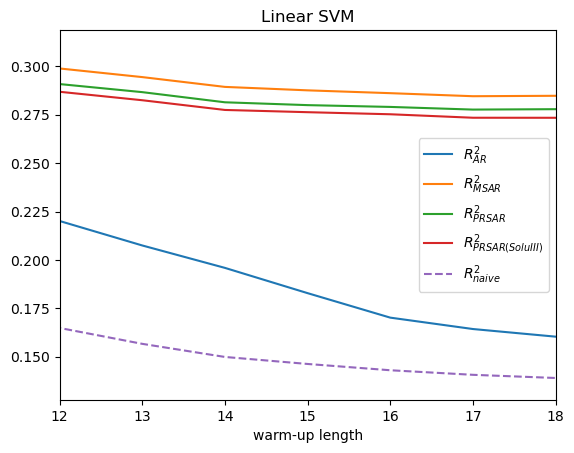

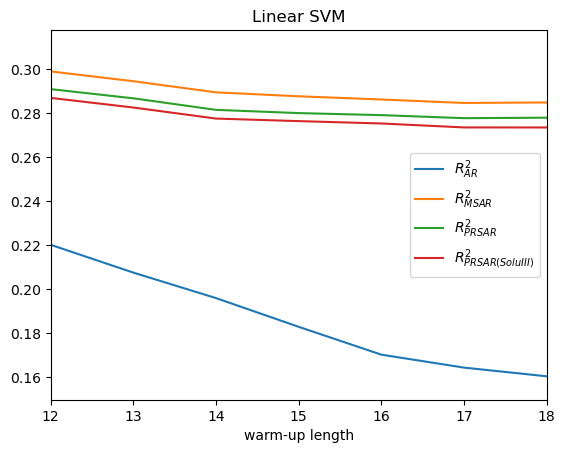

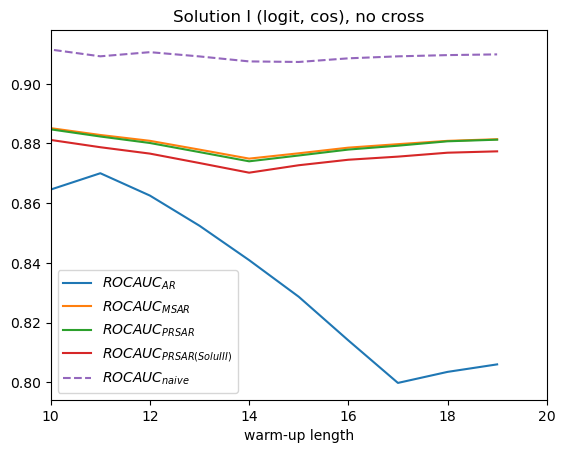

In [84]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3 = [], [], [], [], []
list_y_naive = []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                                    tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar)
    list_y_mslr.append(tmp_r2_mslr)
    list_y_mslrx.append(tmp_r2_mslrx)
    list_y_mslrxsolu3.append(tmp_r2_mslrxsolu3)
    list_y_naive.append(tmp_r2_naive)

plt.plot(list_x, list_y_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_y_mslrxsolu3, label = r'$R^2_{PRSAR (SoluIII)}$')
plt.plot(list_x, list_y_naive, "--", label = r'$R^2_{naive}$')

plt.legend()
plt.xlim(12, 18)
plt.xlabel("warm-up length")
plt.title("Linear SVM")
plt.show()
    
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_y_mslrxsolu3, label = r'$R^2_{PRSAR (SoluIII)}$')

plt.legend()
plt.xlim(12, 18)
plt.xlabel("warm-up length")
plt.title("Linear SVM")
plt.show()

list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3, list_y_naive = [], [], [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                        tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_rocauc_ar)
    list_y_mslr.append(tmp_rocauc_mslr)
    list_y_mslrx.append(tmp_rocauc_mslrx)
    list_y_mslrxsolu3.append(tmp_rocauc_mslrxsolu3)
    list_y_naive.append(tmp_rocauc_naive)

plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR}$')
plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR}$')
plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR}$')
plt.plot(list_x, list_y_mslrxsolu3, label = r'$ROCAUC_{PRSAR (SoluIII)}$')
plt.plot(list_x, list_y_naive, "--", label = r'$ROCAUC_{naive}$')

plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), no cross")
plt.show()
    


### MSLR-X (S-Map with LR)

In [48]:
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()

#data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()

array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()

array_datetime = data_WW_byday["date"].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "temperature", "pH"]].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "pH"]].to_numpy()
#array_cross = data_WW_byday[["salinity", "ODO", "turbidity", "pH"]].to_numpy()
array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature"]].to_numpy()


In [49]:
#reg_method = "LinearRegression"
#reg_method = "RidgeCV"
#reg_method = "LinearSVR"
reg_method = SMap

#reg_method_func = LinearSVR
#reg_method_func = LinearRegression
#reg_method_func = RidgeCV
reg_method_func = SMap

#kargs_reg = {"random_state": 434}
#kargs_reg = {}
kargs_reg = {"theta": 0.5}


In [50]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 21:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

# list_split_index = list(np.where(np.isnan(array_obs))[0])
# list_split_index.append(len(array_obs))
# list_split_index.insert(0, 0)
# list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
# for tmp_index in range(len(list_split_index) - 1):
#     tmp_index_left = list_split_index[tmp_index] + 1
#     tmp_index_right = list_split_index[tmp_index + 1]
#     while tmp_index_right - tmp_index_left > 20:
#         tmp_index_next = min(tmp_index_left + 40, tmp_index_right)
#         list_subseq.append(array_obs[tmp_index_left:tmp_index_next])
#         list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_next])
#         list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_next])
#         tmp_index_left = tmp_index_next
    

In [51]:
[len(i) for i in list_subseq]

[84,
 52,
 91,
 34,
 108,
 86,
 43,
 109,
 23,
 41,
 21,
 90,
 22,
 35,
 56,
 65,
 72,
 118,
 136]

In [52]:
list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
        tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [53]:
n_seq_warmup = 16

In [54]:
start_time = datetime.datetime.now()

list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
list_y_pred_mslrxsolu3 = []
for cc in range(n_seq_warmup, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    tmp_list_y_pred_mslrxsolu3 = []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
    list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
    
    print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
    
    #if cc > 5: break


seq 16 finished 2:14:34.371902
seq 17 finished 5:53:50.590901
seq 18 finished 10:44:38.643904


In [55]:
thres = np.nanquantile(array_obs, 0.95)

list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_res_logitcos_cross = []
for start_index in range(7, 20):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_date).replace(month = 1, day = 1).toordinal()
            #tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= n_seq_warmup and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = reg_method_func(**kargs_reg)
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("AR", tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLRX", tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrxsolu3[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLRX", tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
      
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print("MSLR", tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                                    tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive))
    

7
AR 0.0458830351823688 -0.2799789321380488 0.713326941514861 0.6883988494726749
MSLRX -0.007659011753023748 -0.2799789321380488 0.6807286673058485 0.6883988494726749
MSLRX -0.02052243920407193 -0.2799789321380488 0.677372962607862 0.6883988494726749
MSLR -0.00962636564653141 -0.2799789321380488 0.671620325982742 0.6883988494726749
8
AR 0.04594296875952064 -0.2806831895395234 0.7138014527845036 0.6886198547215496
MSLRX -0.0064584529334617 -0.2806831895395234 0.6803874092009685 0.6886198547215496
MSLRX -0.019170036969388127 -0.2806831895395234 0.676997578692494 0.6886198547215496
MSLR -0.008249989771537125 -0.2806831895395234 0.6716707021791768 0.6886198547215496
9
AR 0.04569009905990418 -0.2808303636912315 0.7128180039138943 0.687866927592955
MSLRX -0.006581913525400607 -0.2808303636912315 0.6790606653620352 0.687866927592955
MSLRX -0.01929189993395264 -0.2808303636912315 0.6756360078277887 0.687866927592955
MSLR -0.00834830519660068 -0.2808303636912315 0.6707436399217221 0.68786692759

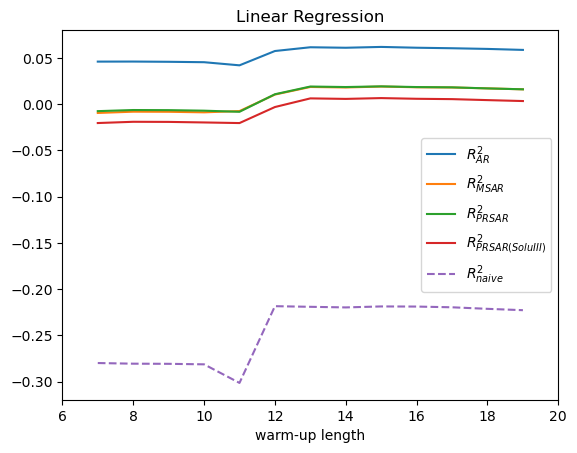

In [56]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3 = [], [], [], [], []
list_y_naive = []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                                    tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar)
    list_y_mslr.append(tmp_r2_mslr)
    list_y_mslrx.append(tmp_r2_mslrx)
    list_y_mslrxsolu3.append(tmp_r2_mslrxsolu3)
    list_y_naive.append(tmp_r2_naive)

plt.plot(list_x, list_y_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_y_mslrxsolu3, label = r'$R^2_{PRSAR (SoluIII)}$')
plt.plot(list_x, list_y_naive, "--", label = r'$R^2_{naive}$')

plt.legend()
plt.xlim(6, 20)
plt.xlabel("warm-up length")
plt.title("Linear Regression")
plt.show()
    

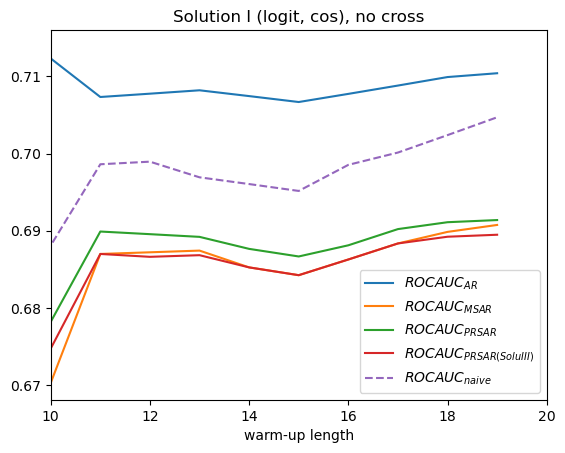

In [57]:
# roc-auc
list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3, list_y_naive = [], [], [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
                        tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_rocauc_ar)
    list_y_mslr.append(tmp_rocauc_mslr)
    list_y_mslrx.append(tmp_rocauc_mslrx)
    list_y_mslrxsolu3.append(tmp_rocauc_mslrxsolu3)
    list_y_naive.append(tmp_rocauc_naive)

plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR}$')
plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR}$')
plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR}$')
plt.plot(list_x, list_y_mslrxsolu3, label = r'$ROCAUC_{PRSAR (SoluIII)}$')
plt.plot(list_x, list_y_naive, "--", label = r'$ROCAUC_{naive}$')

plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), no cross")
plt.show()
    

### MSLR-X (without Solu III, deprecated)

In [8]:
data_WW = data_WW.dropna()
data_WW_byday = data_WW[["date", "conductivity", "salinity", "ODO", "turbidity", "chlorophyll"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()

array_obs = data_WW_byday["chlorophyll"].to_numpy()
array_datetime = data_WW_byday["date"].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "temperature", "pH"]].to_numpy()
#array_cross = data_WW[["conductivity", "salinity", "ODO", "turbidity", "pH"]].to_numpy()
array_cross = data_WW_byday[["salinity", "ODO", "turbidity", "pH"]].to_numpy()

In [9]:
#reg_method = LinearRegression
#reg_method = RidgeCV
reg_method = LinearSVR

In [10]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 40:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

# list_split_index = list(np.where(np.isnan(array_obs))[0])
# list_split_index.append(len(array_obs))
# list_split_index.insert(0, 0)
# list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
# for tmp_index in range(len(list_split_index) - 1):
#     tmp_index_left = list_split_index[tmp_index] + 1
#     tmp_index_right = list_split_index[tmp_index + 1]
#     while tmp_index_right - tmp_index_left > 20:
#         tmp_index_next = min(tmp_index_left + 40, tmp_index_right)
#         list_subseq.append(array_obs[tmp_index_left:tmp_index_next])
#         list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_next])
#         list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_next])
#         tmp_index_left = tmp_index_next
    

In [11]:
[len(i) for i in list_subseq]

[84, 52, 91, 108, 86, 43, 109, 41, 90, 56, 65, 72, 118, 128]

In [12]:
list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
        tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [14]:
start_time = datetime.datetime.now()

list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
for cc in range(4, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False)
        mslrx.reg_method = reg_method
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10)
        mslr.reg_method = reg_method
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
    
    print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        

seq 4 finished 0:04:05.473095
seq 5 finished 0:06:17.031211
seq 6 finished 0:14:24.373862
seq 7 finished 0:17:31.629765
seq 8 finished 0:24:55.882359
seq 9 finished 0:29:17.903963
seq 10 finished 0:34:37.805008
seq 11 finished 0:41:30.275022
seq 12 finished 0:53:51.007037
seq 13 finished 1:08:51.941054


In [15]:
thres = 2.0

list_p_AR = [1, 2, ]
#list_p_AR_cross = [1, 2, ]
list_p_AR_cross = [1, ]
max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

list_res_logitcos_cross = []
for start_index in range(7, 30):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_date).replace(month = 1, day = 1).toordinal()
            tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.extend(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 4 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = reg_method()
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
      
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive))
    
    

7
-0.11743104932416681 -0.06789350646153158 0.9077593675546893 0.965616200996318
-0.023979765823409105 -0.06789350646153158 0.9342917478882391 0.965616200996318
0.0035300395162263243 -0.06789350646153158 0.9179662118258609 0.965616200996318
8
-0.05357287858252624 -0.06882028426179265 0.926932215234102 0.9665129280223619
-0.02033478558428481 -0.06882028426179265 0.9333333333333333 0.9665129280223619
0.0033981722361282607 -0.06882028426179265 0.9186303284416493 0.9665129280223619
9
-0.13450452335378604 -0.0699033894158172 0.9133460383460384 0.9656675906675907
-0.017145155797702927 -0.0699033894158172 0.9341649341649342 0.9656675906675907
0.009844509266696999 -0.0699033894158172 0.9193231693231694 0.9656675906675907
10
-0.08871938093198173 -0.07105605313008656 0.9057211925866238 0.9647237890590027
-0.01699271564190985 -0.07105605313008656 0.9331781418808011 0.9647237890590027
0.009079996236629695 -0.07105605313008656 0.9229414749156893 0.9647237890590027
11
-0.10301397152466651 -0.0780800

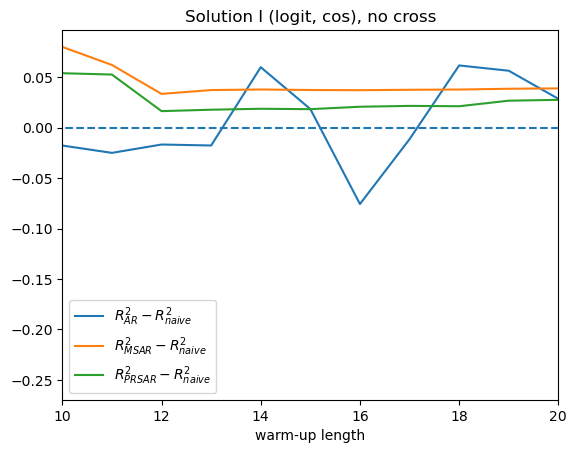

In [16]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar - tmp_r2_naive)
    list_y_mslr.append(tmp_r2_mslr - tmp_r2_naive)
    list_y_mslrx.append(tmp_r2_mslrx - tmp_r2_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR} - R^2_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), no cross")
plt.show()
    

In [17]:
# roc-auc
# list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
# for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
#     len_warmup = cc + 7
#     list_x.append(len_warmup)
#     list_y_ar.append(tmp_rocauc_ar - tmp_rocauc_naive)
#     list_y_mslr.append(tmp_rocauc_mslr - tmp_rocauc_naive)
#     list_y_mslrx.append(tmp_rocauc_mslrx - tmp_rocauc_naive)
    
# plt.hlines(0.0, 0, 100, linestyles = "--")
# plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR} - ROCAUC_{naive}$')
# plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR} - ROCAUC_{naive}$')
# plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR} - ROCAUC_{naive}$')
# plt.legend()
# plt.xlim(10, 20)
# plt.xlabel("warm-up length")
# plt.title("Solution I (logit, cos), no cross")
# plt.show()
    

## End of notebook

In [39]:
period_length = 100
exog = np.transpose([np.sin([i / period_length * 2 * np.pi for i in range(period_length)]), np.cos([i / period_length * 2 * np.pi for i in range(period_length)])])
list_coef_prs = [np.array([[11., 20.], [18., 12.]]), np.array([[14., 16.  ], [15., 16.]])]
#list_intercept_prs = [np.array([0.5, 0.25]), np.array([0.8, 0.03])]
list_intercept_prs = [np.array([0.1, 0.5]), np.array([0.5, 0.1])]
K= 2

for index in range(period_length):
    trans_mat = []
    for ii in range(K):
        tmp_log_prob = exog[index - 1] @ list_coef_prs[ii] + list_intercept_prs[ii]
        tmp_log_prob -= np.max(tmp_log_prob)
        tmp_prob = np.exp(tmp_log_prob)
        tmp_prob /= np.sum(tmp_prob)
        trans_mat.append(tmp_prob)
    trans_mat = np.array(trans_mat)
    
    print(trans_mat)
    

[[0.99787801 0.00212199]
 [0.38403755 0.61596245]]
[[0.99631576 0.00368424]
 [0.35434369 0.64565631]]
[[0.99345863 0.00654137]
 [0.32659902 0.67340098]]
[[0.98816384 0.01183616]
 [0.30094936 0.69905064]]
[[0.97827425 0.02172575]
 [0.27746925 0.72253075]]
[[0.95981667 0.04018333]
 [0.25617158 0.74382842]]
[[0.92588871 0.07411129]
 [0.23701942 0.76298058]]
[[0.86594114 0.13405886]
 [0.21993836 0.78006164]]
[[0.76798153 0.23201847]
 [0.20482836 0.79517164]]
[[0.62762864 0.37237136]
 [0.19157415 0.80842585]]
[[0.46096122 0.53903878]
 [0.18005402 0.81994598]]
[[0.30238522 0.69761478]
 [0.17014676 0.82985324]]
[[0.18038571 0.81961429]
 [0.16173688 0.83826312]]
[[0.1009138  0.8990862 ]
 [0.15471844 0.84528156]]
[[0.05450403 0.94549597]
 [0.14899765 0.85100235]]
[[0.02902691 0.97097309]
 [0.14449457 0.85550543]]
[[0.01545204 0.98454796]
 [0.14114417 0.85885583]]
[[0.00829321 0.99170679]
 [0.13889686 0.86110314]]
[[0.00451314 0.99548686]
 [0.13771886 0.86228114]]
[[0.00250048 0.99749952]
 [0.13